# Task 2: Visualize hidden represenations of a model

In [1]:
# import h5py
# 
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

In [2]:
packages_to_install = {
    "ipywidgets": "ipywidgets",
    "numpy": "numpy=1.24.0",
    "torch": "torch",
    "matplotlib": "matplotlib",
    "sentencepiece": "sentencepiece",
    "protobuf": "protobuf",
    "datasets": "datasets",
    "transformers": "transformers",
    "diffusers": "diffusers",
    "peft": "peft",
    "h5py": "h5py",
    "scikit-learn": "scikit-learn",
    "scipy": "scipy",
    "wandb": "wandb",
    "altair": "-c conda-forge altair",
}

In [3]:
%%time
import importlib

for package_name, install_command in packages_to_install.items():
    try:
        importlib.import_module(package_name)
        print(f"{package_name} is already installed.")
    except ImportError:
        print(f"{package_name} is not installed. Installing it now...")
        !conda install -y {install_command}

ipywidgets is already installed.
numpy is already installed.
torch is already installed.
matplotlib is already installed.
sentencepiece is already installed.
protobuf is not installed. Installing it now...
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.2



# All requested packages already installed.

datasets is already installed.
transformers is already installed.
diffusers is already installed.
peft is already installed.
h5py is not installed. Installing it now...
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages upda

In [4]:
# import dependencies
import matplotlib.pyplot as plt
import numpy as np
import torch

from datasets import load_dataset, load_dataset_builder, get_dataset_split_names, get_dataset_config_names
from transformers import XGLMTokenizer, XGLMTokenizerFast, XGLMForCausalLM, AutoModelForCausalLM, AutoTokenizer, GenerationConfig

In [8]:
DATA_SET_NAME = "facebook/flores"
MODEL_NAME = "facebook/xglm-564M"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LANGUAGES = [
    "eng_Latn",
    "spa_Latn",
    "deu_Latn",
    "arb_Arab",
    "tel_Telu",
    "tam_Taml",
    "quy_Latn"
]

In [10]:
%%time
language_flores_data = {}
for language in LANGUAGES:
    print(language)
    language_flores_data[language] = load_dataset_builder(DATA_SET_NAME, language, trust_remote_code=True)
    language_flores_data[language].download_and_prepare()

language_flores_data

eng_Latn


Using the latest cached version of the module from /home/reni/.cache/huggingface/modules/datasets_modules/datasets/facebook--flores/2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef (last modified on Tue Mar 12 01:26:11 2024) since it couldn't be found locally at facebook/flores, or remotely on the Hugging Face Hub.


spa_Latn
deu_Latn
arb_Arab
tel_Telu
tam_Taml
quy_Latn
CPU times: user 530 ms, sys: 42.9 ms, total: 573 ms
Wall time: 36.5 s


{'eng_Latn': <datasets_modules.datasets.facebook--flores.2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef.flores.Flores200 at 0x7fcbac893d00>,
 'spa_Latn': <datasets_modules.datasets.facebook--flores.2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef.flores.Flores200 at 0x7fcbb0ab05b0>,
 'deu_Latn': <datasets_modules.datasets.facebook--flores.2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef.flores.Flores200 at 0x7fcba7a13bb0>,
 'arb_Arab': <datasets_modules.datasets.facebook--flores.2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef.flores.Flores200 at 0x7fcba7a139a0>,
 'tel_Telu': <datasets_modules.datasets.facebook--flores.2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef.flores.Flores200 at 0x7fcba7a13dc0>,
 'tam_Taml': <datasets_modules.datasets.facebook--flores.2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef.flores.Flores200 at 0x7fcba7a13850>,
 'quy_Latn': <datasets_modules.datasets.facebo

In [11]:
eng_dataset = language_flores_data["eng_Latn"].as_dataset()
eng_dataset

DatasetDict({
    dev: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence'],
        num_rows: 997
    })
    devtest: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence'],
        num_rows: 1012
    })
})

In [12]:
# tokenize the data

# load a pre-trained tokenizer from the huggingface hub
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# gpt2 does not have a padding token, so we have to add it manually
if MODEL_NAME == "gpt2":
    tokenizer.add_special_tokens({'pad_token': tokenizer.unk_token})

# specify the tokenization function
def tokenize_function(example):
    return tokenizer(example['sentence'])
# TODO: your code goes here

tokenized_datasets = {lang: language_flores_data[lang].as_dataset().map(tokenize_function, batched=True) for lang in LANGUAGES}

In [13]:
for key, data in tokenized_datasets.items():
    tokenized_datasets[key] = tokenized_datasets[key].remove_columns(["id", "URL", "domain", "topic", "has_image", "has_hyperlink", "sentence"])
    tokenized_datasets[key].set_format("torch")
tokenized_datasets

{'eng_Latn': DatasetDict({
     dev: Dataset({
         features: ['input_ids', 'attention_mask'],
         num_rows: 997
     })
     devtest: Dataset({
         features: ['input_ids', 'attention_mask'],
         num_rows: 1012
     })
 }),
 'spa_Latn': DatasetDict({
     dev: Dataset({
         features: ['input_ids', 'attention_mask'],
         num_rows: 997
     })
     devtest: Dataset({
         features: ['input_ids', 'attention_mask'],
         num_rows: 1012
     })
 }),
 'deu_Latn': DatasetDict({
     dev: Dataset({
         features: ['input_ids', 'attention_mask'],
         num_rows: 997
     })
     devtest: Dataset({
         features: ['input_ids', 'attention_mask'],
         num_rows: 1012
     })
 }),
 'arb_Arab': DatasetDict({
     dev: Dataset({
         features: ['input_ids', 'attention_mask'],
         num_rows: 997
     })
     devtest: Dataset({
         features: ['input_ids', 'attention_mask'],
         num_rows: 1012
     })
 }),
 'tel_Telu': DatasetDict({
 

In [14]:
# construct a pytorch data loader for each dataset
from typing import Dict
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling
BATCH_SIZE = 1

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

flores_dataloaders: Dict[str, Dict[str, DataLoader]] = {}
# Iterate over languages
for language in LANGUAGES:
    flores_dataloaders[language] = {}  # Initialize a dictionary for each language
    # Iterate over data splits for the current language
    for split_name, dataset in tokenized_datasets[language].items():
        flores_dataloaders[language][split_name] = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=data_collator, shuffle=True) # Shuffle is True because we need random 200 sentences
flores_dataloaders
# TODO: your code goes here

{'eng_Latn': {'dev': <torch.utils.data.dataloader.DataLoader at 0x7fcbac7309a0>,
  'devtest': <torch.utils.data.dataloader.DataLoader at 0x7fcbac730ac0>},
 'spa_Latn': {'dev': <torch.utils.data.dataloader.DataLoader at 0x7fcbac857790>,
  'devtest': <torch.utils.data.dataloader.DataLoader at 0x7fcba4a6c190>},
 'deu_Latn': {'dev': <torch.utils.data.dataloader.DataLoader at 0x7fcba4a6dab0>,
  'devtest': <torch.utils.data.dataloader.DataLoader at 0x7fcba4a6dae0>},
 'arb_Arab': {'dev': <torch.utils.data.dataloader.DataLoader at 0x7fcba4a6c4f0>,
  'devtest': <torch.utils.data.dataloader.DataLoader at 0x7fcba4a6d570>},
 'tel_Telu': {'dev': <torch.utils.data.dataloader.DataLoader at 0x7fcba4a6d660>,
  'devtest': <torch.utils.data.dataloader.DataLoader at 0x7fcba4a6d750>},
 'tam_Taml': {'dev': <torch.utils.data.dataloader.DataLoader at 0x7fcba4a6d840>,
  'devtest': <torch.utils.data.dataloader.DataLoader at 0x7fcba4a6d990>},
 'quy_Latn': {'dev': <torch.utils.data.dataloader.DataLoader at 0x7fcb

In [15]:
for sentenceCounter in flores_dataloaders['eng_Latn']['dev']:
    print(sentenceCounter)
    break

{'input_ids': tensor([[     2,   3573,    256, 199412, 236897,   6698,      4,    540,    319,
          72794,   1022,   1680,   1413,  11249,   1245,    778,  12734,     48,
             57, 183556,     33,  26482,   4447,    901]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([[     2,   3573,    256, 199412, 236897,   6698,      4,    540,    319,
          72794,   1022,   1680,   1413,  11249,   1245,    778,  12734,     48,
             57, 183556,     33,  26482,   4447,    901]])}


In [16]:
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.eval()

/home/reni/miniconda3/envs/hws_ws23/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


XGLMForCausalLM(
  (model): XGLMModel(
    (embed_tokens): Embedding(256008, 1024, padding_idx=1)
    (embed_positions): XGLMSinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0-23): 24 x XGLMDecoderLayer(
        (self_attn): XGLMAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (activation_fn): GELUActivation()
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine

In [17]:
# Check if GPU is available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [166]:
import os

counter_file = "experiment_counter.txt"
experimentCounter = 0

# Check if counter file exists
if os.path.exists(counter_file):
    # Read counter from file
    with open(counter_file, 'r') as f:
        experimentCounter = int(f.read())

filename = f"{experimentCounter}_hidden_representations.hdf5"

# Increment counter
experimentCounter += 1
with open(counter_file, 'w') as f:
    f.write(str(experimentCounter))

In [20]:
!conda install -y h5py

done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.2



# All requested packages already installed.



In [22]:
import h5py

def add_groups(name, f: h5py.File) -> h5py.Group:
    return f.create_group(name)

In [170]:
%%time
import h5py
import random

# Check if GPU is available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

# Initialize list to store random batches
random_batches = []

# Number of random batches to select per language
num_random_batches = 200

with h5py.File(filename, 'w') as f:
    # Iterate over languages
    for lang, loaders in flores_dataloaders.items():
        # Flatten loaders for current language
        all_loaders = [(split, loader) for split, loader in loaders.items()]
        # Randomly select a DataLoader (and its corresponding split name)
        split, loader = random.choice(all_loaders)
        sentenceCounter = 0
        # lang_grp = add_groups(lang, f) # Create Lang group
        for batch in loader:
            print(f"{lang} {split} {sentenceCounter}")
            with torch.no_grad():
                inputs = batch.to(device=device)
                labels = inputs["input_ids"]
                # print(labels)
                outputs = model(**inputs, output_hidden_states=True)
                loss = outputs.loss.cpu()
                hidden_states = outputs.hidden_states
                # sentence_grp = add_groups(f"sentence:{i}", f)
                for layer_num, layer_hidden_states in enumerate(hidden_states):
                    for labelIndex, label in enumerate(labels):
                        tokens = tokenizer.convert_ids_to_tokens(label)
                        # Save hidden state of each token individually
                        for idx, token in enumerate(tokens):
                            uniqueTokenId = f'{lang}/s:{sentenceCounter}/l:{layer_num}/t:{idx}'
                            token_hidden_state = layer_hidden_states[labelIndex][idx].cpu()
                            token_dataset = f.create_dataset(uniqueTokenId, data=token_hidden_state)
                            token_dataset.attrs['decoded_token'] = token
                            # print(token, label[idx].cpu().numpy())
                        # Save hidden state of whole sentence by mean-pooling
                        uniqueSentenceId = f'{lang}/s:{sentenceCounter}/l:{layer_num}/sentence'
                        meanSentenceHiddenState = layer_hidden_states[labelIndex].mean(dim=0).cpu()
                        sentence_dataset = f.create_dataset(uniqueSentenceId, data=meanSentenceHiddenState)
                        decoded_label = tokenizer.decode(label)
                        sentence_dataset.attrs['decoded_sentence'] = decoded_label
                        # print(decoded_label)
                        
                        # len(tokens) == layer_hidden_states[labelIndex].size(0)
                        # print("--")
                        # print(layer_hidden_states[labelIndex].size(0))
                        # print(len(tokens))
                        # print("--")
                        # print(f"{lang} {split} {i} {layer_num} {tokens}")
                        # print(f"Decoded Label: {tokenizer.decode(label)}")
                # Ensures we get only 200 sentences (batches)
                random_batches.append((lang, split, batch))
                sentenceCounter += 1
                if sentenceCounter >= num_random_batches:
                    break

# Iterate over random batches and print them
# for lang, split, batch in random_batches:
#     print(f"Language: {lang}, Split: {split}")
#     print(batch)  # Assuming batch is a tensor or another iterable data structure

cuda
eng_Latn devtest 0
eng_Latn devtest 1
eng_Latn devtest 2
eng_Latn devtest 3
eng_Latn devtest 4
eng_Latn devtest 5
eng_Latn devtest 6
eng_Latn devtest 7
eng_Latn devtest 8
eng_Latn devtest 9
eng_Latn devtest 10
eng_Latn devtest 11
eng_Latn devtest 12
eng_Latn devtest 13
eng_Latn devtest 14
eng_Latn devtest 15
eng_Latn devtest 16
eng_Latn devtest 17
eng_Latn devtest 18
eng_Latn devtest 19
eng_Latn devtest 20
eng_Latn devtest 21
eng_Latn devtest 22
eng_Latn devtest 23
eng_Latn devtest 24
eng_Latn devtest 25
eng_Latn devtest 26
eng_Latn devtest 27
eng_Latn devtest 28
eng_Latn devtest 29
eng_Latn devtest 30
eng_Latn devtest 31
eng_Latn devtest 32
eng_Latn devtest 33
eng_Latn devtest 34
eng_Latn devtest 35
eng_Latn devtest 36
eng_Latn devtest 37
eng_Latn devtest 38
eng_Latn devtest 39
eng_Latn devtest 40
eng_Latn devtest 41
eng_Latn devtest 42
eng_Latn devtest 43
eng_Latn devtest 44
eng_Latn devtest 45
eng_Latn devtest 46
eng_Latn devtest 47
eng_Latn devtest 48
eng_Latn devtest 49
eng_L

In [23]:
with h5py.File(filename, 'r') as f:
    print(f.keys())
    print(f["eng_Latn"]['s:0'].keys())
    print(f["eng_Latn"]['s:0']['l:0'])
    print(f["eng_Latn"]['s:0']['l:0'].keys())
    print(f["eng_Latn"]['s:0']['l:0']['sentence'])
    print(f["eng_Latn"]['s:0']['l:0']['t:0'])
    
    token0 = f["eng_Latn"]['s:0']['l:0']['t:0'][()]
    print(dir(f["eng_Latn"]['s:0']['l:0']['t:0']))
    print(dir(f["eng_Latn"]['s:0']['l:0']['t:0'].attrs))
    print(f["eng_Latn"]['s:0']['l:0']['t:0'].attrs.keys())
    print(f["eng_Latn"]['s:0']['l:0']['t:0'].attrs["decoded_token"])
    print(f["eng_Latn"]['s:5']['l:0']['sentence'].attrs["decoded_sentence"])
    
    print("-----")
    # 7 languages, 200 batches / sentences / labels, 25 layers, t tokens
    # 1 embedding layer, 24 decoding layers
    print(f["eng_Latn"]['s:0']["l:0"]['sentence'])

<KeysViewHDF5 ['arb_Arab', 'deu_Latn', 'eng_Latn', 'quy_Latn', 'spa_Latn', 'tam_Taml', 'tel_Telu']>
<KeysViewHDF5 ['l:0', 'l:1', 'l:10', 'l:11', 'l:12', 'l:13', 'l:14', 'l:15', 'l:16', 'l:17', 'l:18', 'l:19', 'l:2', 'l:20', 'l:21', 'l:22', 'l:23', 'l:24', 'l:3', 'l:4', 'l:5', 'l:6', 'l:7', 'l:8', 'l:9']>
<HDF5 group "/eng_Latn/s:0/l:0" (25 members)>
<KeysViewHDF5 ['sentence', 't:0', 't:1', 't:10', 't:11', 't:12', 't:13', 't:14', 't:15', 't:16', 't:17', 't:18', 't:19', 't:2', 't:20', 't:21', 't:22', 't:23', 't:3', 't:4', 't:5', 't:6', 't:7', 't:8', 't:9']>
<HDF5 dataset "sentence": shape (1024,), type "<f4">
<HDF5 dataset "t:0": shape (1024,), type "<f4">
['__array__', '__bool__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__'

In [24]:
with h5py.File(filename, 'r') as f:
    for layer in range(25):
        print(f["eng_Latn"]['s:0'][f"l:{layer}"]['t:1'].attrs["decoded_token"])

▁He
▁He
▁He
▁He
▁He
▁He
▁He
▁He
▁He
▁He
▁He
▁He
▁He
▁He
▁He
▁He
▁He
▁He
▁He
▁He
▁He
▁He
▁He
▁He
▁He


# Visualization

### We need to apply PCA to the hidden representations of each language from the first layer of the model

In [59]:
# with h5py.File(filename, 'r') as f:
#     token_idx = 0
#     idx = 0
#     path = f"{language}/s:{idx}/l:{layer}"
#     print(path)
#     print(f[path])
#     print(f[path].keys())
#     for key in f[path].keys():
#         if (key != "sentence"):
#             print(key)
#             hidden_representation = f[path][key]
#             print(hidden_representation)
# 
#         token_idx += 1

eng_Latn/s:0/l:0
<HDF5 group "/eng_Latn/s:0/l:0" (25 members)>
<KeysViewHDF5 ['sentence', 't:0', 't:1', 't:10', 't:11', 't:12', 't:13', 't:14', 't:15', 't:16', 't:17', 't:18', 't:19', 't:2', 't:20', 't:21', 't:22', 't:23', 't:3', 't:4', 't:5', 't:6', 't:7', 't:8', 't:9']>
t:0
<HDF5 dataset "t:0": shape (1024,), type "<f4">
t:1
<HDF5 dataset "t:1": shape (1024,), type "<f4">
t:10
<HDF5 dataset "t:10": shape (1024,), type "<f4">
t:11
<HDF5 dataset "t:11": shape (1024,), type "<f4">
t:12
<HDF5 dataset "t:12": shape (1024,), type "<f4">
t:13
<HDF5 dataset "t:13": shape (1024,), type "<f4">
t:14
<HDF5 dataset "t:14": shape (1024,), type "<f4">
t:15
<HDF5 dataset "t:15": shape (1024,), type "<f4">
t:16
<HDF5 dataset "t:16": shape (1024,), type "<f4">
t:17
<HDF5 dataset "t:17": shape (1024,), type "<f4">
t:18
<HDF5 dataset "t:18": shape (1024,), type "<f4">
t:19
<HDF5 dataset "t:19": shape (1024,), type "<f4">
t:2
<HDF5 dataset "t:2": shape (1024,), type "<f4">
t:20
<HDF5 dataset "t:20": shap

In [67]:
import h5py
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def get_data(language='eng_Latn', layer=0, representation_type='sentence'):
    with h5py.File(filename, 'r') as f:
        hidden_representations = []
        for idx in range(200):
            # Construct the HDF5 key based on the representation type
            if representation_type == 'token':
                path = f"{language}/s:{idx}/l:{layer}"
                # print(path)
                # If token representation, iterate through all tokens for each sentence
                for key in f[path].keys():
                    if key != "sentence":
                        # print(key)
                        hidden_representation = f[path][key][()]
                        hidden_representations.append(hidden_representation)
            else:
                key = f"{language}/s:{idx}/l:{layer}/sentence"
                # For sentence representation, directly append the representation
                if key in f:
                    hidden_representation = f[key][()]
                    hidden_representations.append(hidden_representation)

        # Return a stacked array of all representations
        return np.vstack(hidden_representations)

def getPCAData(language='eng_Latn', layer=0, representation_type='sentence'):
    data = get_data(language, layer, representation_type)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    return pca_result

def getTSNEData(language='eng_Latn', layer=0, representation_type='sentence'):
    data = get_data(language, layer, representation_type)
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
    tsne_result = tsne.fit_transform(data)
    return tsne_result

### Show 25 layers (PCA and t-SNE) sentences with matplotlib side-by-side

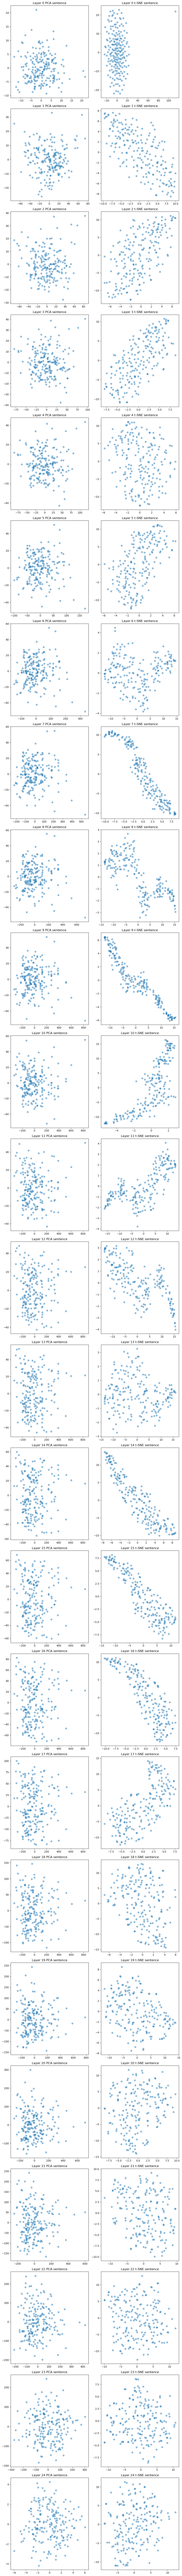

In [70]:
import matplotlib.pyplot as plt

language = 'eng_Latn'
num_layers = 25

# Initialize the plot
fig, axes = plt.subplots(nrows=num_layers, ncols=2, figsize=(10, 140))

for layer in range(num_layers):
    pca_result = getPCAData(language, layer)
    tsne_result = getTSNEData(language, layer)

    # Plot PCA
    axes[layer, 0].scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
    axes[layer, 0].set_title(f'Layer {layer} PCA sentence')

    # Plot t-SNE
    axes[layer, 1].scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
    axes[layer, 1].set_title(f'Layer {layer} t-SNE sentence')

plt.tight_layout()
plt.show()


### Show 25 layers (PCA and t-SNE) tokens with matplotlib side-by-side

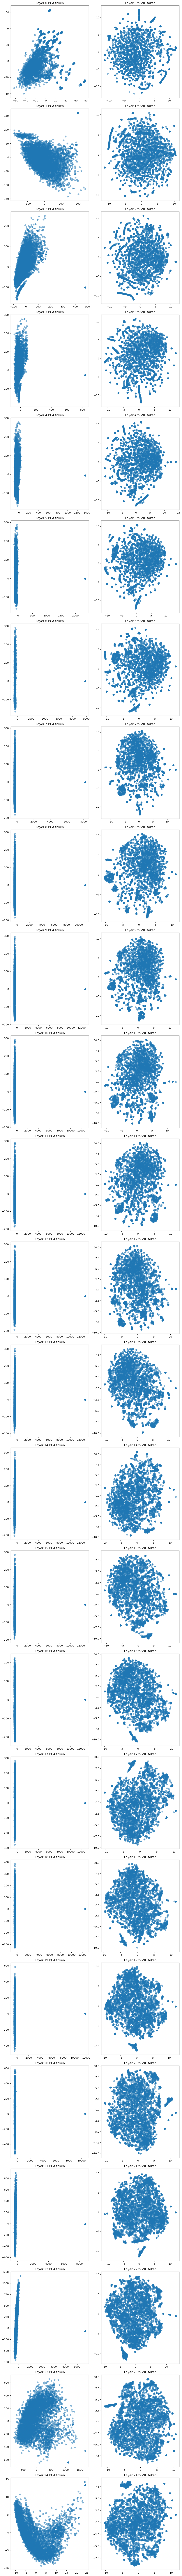

In [74]:
import matplotlib.pyplot as plt

language = 'eng_Latn'
num_layers = 25

# x_min, x_max = -100, 100
# y_min, y_max = -100, 100
# Initialize the plot
fig, axes = plt.subplots(nrows=num_layers, ncols=2, figsize=(10, 140))

for layer in range(num_layers):
    pca_result = getPCAData(language, layer, representation_type='token')
    tsne_result = getTSNEData(language, layer, representation_type='token')

    # Plot PCA
    axes[layer, 0].scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
    # axes[layer, 0].set_xlim(x_min, x_max)
    # axes[layer, 0].set_ylim(y_min, y_max)
    axes[layer, 0].set_title(f'Layer {layer} PCA token')

    # Plot t-SNE
    axes[layer, 1].scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
    # axes[layer, 1].set_xlim(x_min, x_max)
    # axes[layer, 1].set_ylim(y_min, y_max)
    axes[layer, 1].set_title(f'Layer {layer} t-SNE token')

plt.tight_layout()
plt.show()


### Show interactive plot using Altair for layer=0 (PCA and t-SNE) sentence

In [270]:
import h5py
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import altair as alt

def getPCAData(language='eng_Latn', layer=0):
    with h5py.File(filename, 'r') as f:
        hidden_representations, decoded_sentences = [], []
        for sentence_idx in range(200):  # Assuming sentence indices go from 0 to 200
            hidden_representation = f[language][f's:{sentence_idx}'][f'l:{layer}']['sentence'][()]
            hidden_representations.append(hidden_representation)
            # Collect decoded sentences
            decoded_sentence = f[language][f's:{sentence_idx}'][f'l:{layer}']['sentence'].attrs["decoded_sentence"]
            decoded_sentences.append(decoded_sentence)
        hidden_representations = np.vstack(hidden_representations)
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(hidden_representations)
        # Create a DataFrame
        df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
        df['decoded_sentence'] = decoded_sentences
        return df

def getTSNEData(language='eng_Latn', layer=0):
    with h5py.File(filename, 'r') as f:
        hidden_representations, decoded_sentences = [], []
        for sentence_idx in range(200):
            hidden_representation = f[language][f's:{sentence_idx}'][f'l:{layer}']['sentence'][()]
            hidden_representations.append(hidden_representation)
            # Collect decoded sentences
            decoded_sentence = f[language][f's:{sentence_idx}'][f'l:{layer}']['sentence'].attrs["decoded_sentence"]
            decoded_sentences.append(decoded_sentence)
        hidden_representations = np.vstack(hidden_representations)
        tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
        tsne_result = tsne.fit_transform(hidden_representations)
        # Create a DataFrame
        df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
        df['decoded_sentence'] = decoded_sentences
        return df

# Example usage for a single layer
language = 'eng_Latn'
layer = 0  # Adjust as needed

# Get data
pca_df = getPCAData(language, layer)
tsne_df = getTSNEData(language, layer)

# Create Altair charts
pca_chart = alt.Chart(pca_df).mark_circle(size=60).encode(
    x='PCA1',
    y='PCA2',
    tooltip=['decoded_sentence']
).interactive().properties(
    title=f'PCA Visualization for {language} Layer {layer}',
    width=300,
    height=300
)

tsne_chart = alt.Chart(tsne_df).mark_circle(size=60).encode(
    x='TSNE1',
    y='TSNE2',
    tooltip=['decoded_sentence']
).interactive().properties(
    title=f't-SNE Visualization for {language} Layer {layer}',
    width=300,
    height=300
)

# Display the charts side by side
alt.hconcat(pca_chart, tsne_chart)

alt.HConcatChart(...)

### Show interactive widget for all layers (25) sentence using Altair (PCA and t-SNE)

In [82]:
import h5py
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import altair as alt
from ipywidgets import interact, IntSlider, VBox

def get_data_for_layer(language, layer):
    with h5py.File(filename, 'r') as f:
        hidden_representations, decoded_sentences = [], []
        for sentence_idx in range(200):
            hidden_representation = f[language][f's:{sentence_idx}'][f'l:{layer}']['sentence'][()]
            hidden_representations.append(hidden_representation)
            decoded_sentence = f[language][f's:{sentence_idx}'][f'l:{layer}']['sentence'].attrs["decoded_sentence"]
            decoded_sentences.append(decoded_sentence)
        hidden_representations = np.vstack(hidden_representations)
        return hidden_representations, decoded_sentences

def create_pca_tsne_charts_for_all_languages(layer):
    charts = []  # This will hold all the charts for the languages
    for language in LANGUAGES:
        # Get data
        data, decoded_sentences = get_data_for_layer(language, layer)

        # PCA
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(data)
        pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
        pca_df['decoded_sentence'] = decoded_sentences

        # t-SNE
        tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
        tsne_result = tsne.fit_transform(data)
        tsne_df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
        tsne_df['decoded_sentence'] = decoded_sentences

        # PCA Chart
        pca_chart = alt.Chart(pca_df).mark_circle(size=60).encode(
            x='PCA1',
            y='PCA2',
            tooltip=['decoded_sentence']
        ).properties(
            title=f'PCA for {language} Layer {layer}',
            width=300,
            height=300
        ).interactive()

        # t-SNE Chart
        tsne_chart = alt.Chart(tsne_df).mark_circle(size=60).encode(
            x='TSNE1',
            y='TSNE2',
            tooltip=['decoded_sentence']
        ).properties(
            title=f't-SNE for {language} Layer {layer}',
            width=300,
            height=300
        ).interactive()

        # Combine PCA and t-SNE charts for the current language
        combined_chart = pca_chart | tsne_chart
        charts.append(combined_chart)

    return charts

# Interactive widget
@interact
def show_plots(layer=IntSlider(min=0, max=24, step=1, value=0)):
    charts = create_pca_tsne_charts_for_all_languages(layer)
    # Since displaying multiple charts directly might not work as expected,
    # consider displaying them one by one or explore other ways to aggregate them.
    for chart in charts:
        display(chart)

interactive(children=(IntSlider(value=0, description='layer', max=24), Output()), _dom_classes=('widget-intera…

Notes:
- Part 1:
    - Hidden states extracted for both sentences and tokens.
    - Taken 200 random batches (random split, shuffled dataLoaders).
    - Size of hdf5 file is approx\. 6 GB
- Part 2:
    - Applied PCA and t-SNE to all languages for sentences
    - Applied PCA and t-SNE for only English for both sentences and tokens      
    - (if time permits: apply PCA and t-SNE for all languages for tokens too)
    - Discuss observations